In [2]:
import torch
import numpy as np
import abel
from glob import glob
from torchvision.utils import make_grid
from torchvision.transforms import ToPILImage
from matplotlib import pyplot as plt

from dii.models.base import VAE
from dii.visualization.visualize import show_torch_grid, radial_profile
from dii.pipeline.datautils import get_benchmark_imageset

plt.style.use("publication")

# TL;DR

Use neural networks to perform variational inference for noisy image reconstruction.

# Probabilistic ion image reconstruction

In charged particle experiments such as velocity-mapped ion imaging (VMI), we measure the kinetic energy and recoil distributions of ions and/or electrons to understand some process: in chemistry, for example, we can measure the energy released following a photolysis reaction by observing one of the co-fragments and seeing if there are peculiarities in the anisotropy, whether there are abnormal dependencies on photolysis wavelength, etc.

How these experiments work is by using a laser to start the process, and with a time-of-flight spectrometer we accelerate the charged particles into a position-sensitive detector (e.g. multichannel plate), and in ion imaging experiments, we record the positions of each particle with a CCD. Through this process, what we are actually observing is the 2D projection of a 3D Newton sphere of particles, and in order to perform our analysis, we need to recover the original 3D distribution and look at the central slice of the sphere only.

Conventionally, we've relied on the inverse Abel transform, which is an analytic method that can reconstruct the 3D distribution from a 2D one assuming cylindrical symmetry. Because the integrals are difficult to compute exactly, these are often done numerically in some basis set expansion.

The trouble with these methods, however, is that they perform poorly with noisy images, and introduce a significant amount of artifacts into the image.

Loading basis sets...
Updating regularization...
Calculating correction...
Using memory-cached basis sets
Using memory-cached basis sets
Using memory-cached basis sets


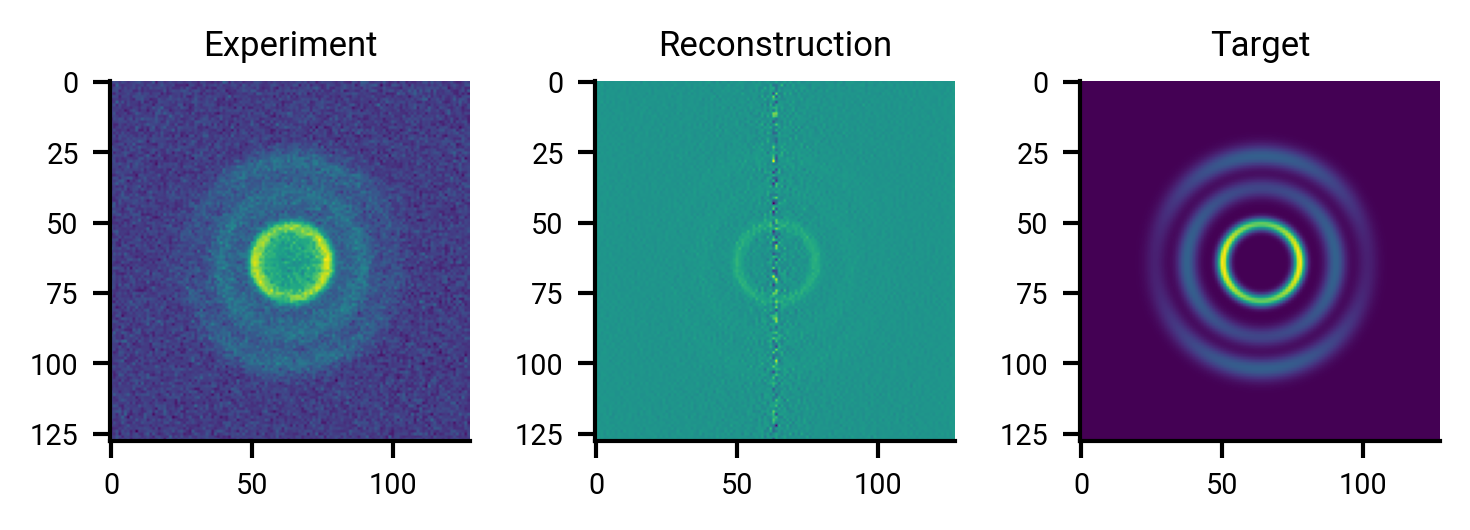

In [3]:
example = np.loadtxt("../../data/processed/inputs/50.dat")
target = np.loadtxt("../../data/processed/outputs/50.dat")
transform = abel.Transform(example, direction="inverse", method="basex").transform;

fig, axarray = plt.subplots(1, 3, figsize=(5, 3))

for ax, image, title in zip(axarray, [example, transform, target], ["Experiment", "Reconstruction", "Target"]):
    ax.imshow(image)
    ax.set(title=title)

Ultimately what we actually want is the radial and angular profile of the image: the distance from the center is directly proportional to the speed of the particle. As you can see in the reconstruction above, noise gathers towards the central strip of the image which heavily deteroriates the image quality.

[Text(0, 0.5, '$p(r)$'), Text(0.5, 0, 'Radial distance ($r$ / pixels)')]

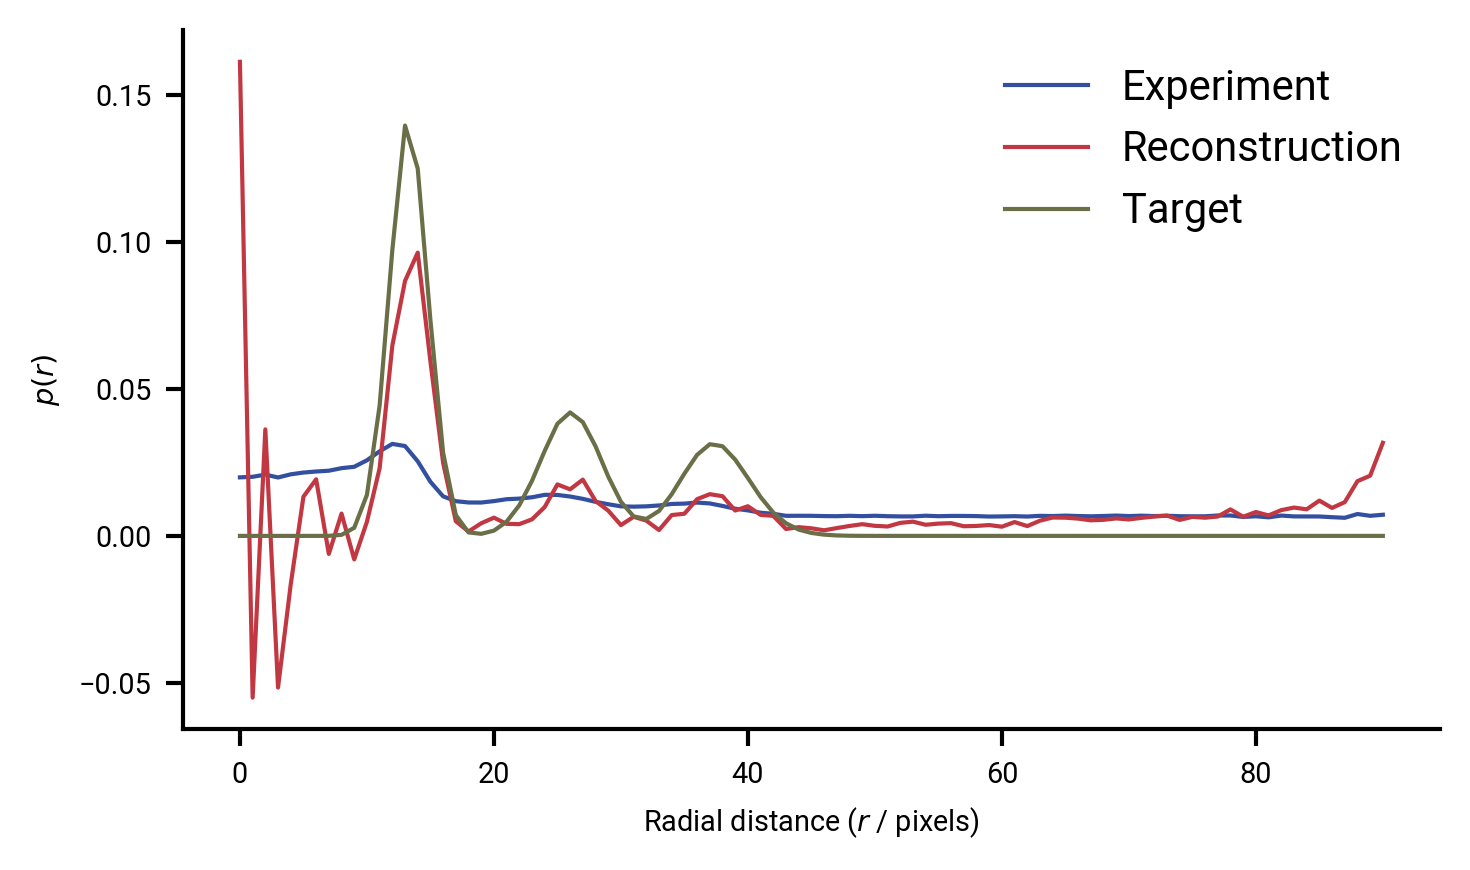

In [4]:
fig, ax = plt.subplots(figsize=(5,3))

for img, title in zip([example, transform, target], ["Experiment", "Reconstruction", "Target"]):
    profile = radial_profile(img, center=(64, 64))
    ax.plot(profile / profile.sum(), label=title)
ax.legend()
ax.set(ylabel="$p(r)$", xlabel="Radial distance ($r$ / pixels)")

While you could do more image processing and filtering, you are still compromising SNR _and_ resolution. Perhaps one of the more important things is that, despite being photon starved, we are not doing an adequate treatment of noise (either Gaussian or Poisson) on a pixel-by-pixel basis. Similarly, for an otherwise highly quantitative method, we have no measure of uncertainty in the reconstruction: what you see is what you get.

## Using deep learning

One approach that _could_ address some, if not all of these problems, is the parameterize a neural network. Here, what we are doing is using a neural network to simultaneously denoise an image, and reconstruct it, on the basis of deep neural networks as universal function approximators.

Some details are below, but essentially we train a convolutional autoencoder model to learn the mapping between a noisy, 2D projection and the noise-free reconstruction by maximizing the paramteric likelihood $p_\theta(x)$. The encoder looks at an image, extracts and compresses features into a low dimensional representation $z$, which is then used to draw samples from an approximate Gaussian posterior [$q_\theta(z)$] that is learned throughout training. This representation is then used by a decoder model with a similar architecture to reconstruct the original image. Because the encoding part is probabilistic, we can generate multiple potential images given a single input image each weighted by the posterior likelihood.

The advantage of this approach is that it's incredibly fast (~1200 images per second on a Nvidia 3080) because it's variational. 

In this notebook, I'll show off some very quick and preliminary (trained in a few hours) results on a benchmark dataset: these images are simulated from the same distribution, however have not been seen during training.

The pipeline involves:

1. Simulate the 3D distribution analytically
2. Project the image onto a 2D mapping
3. Inject a combination of Poisson (signal-dependent) and Gaussian (thermal) noise into projection
4. Use neural network to reconstruct

### Benchmark set

In [5]:
input_images, target_images = get_benchmark_imageset()

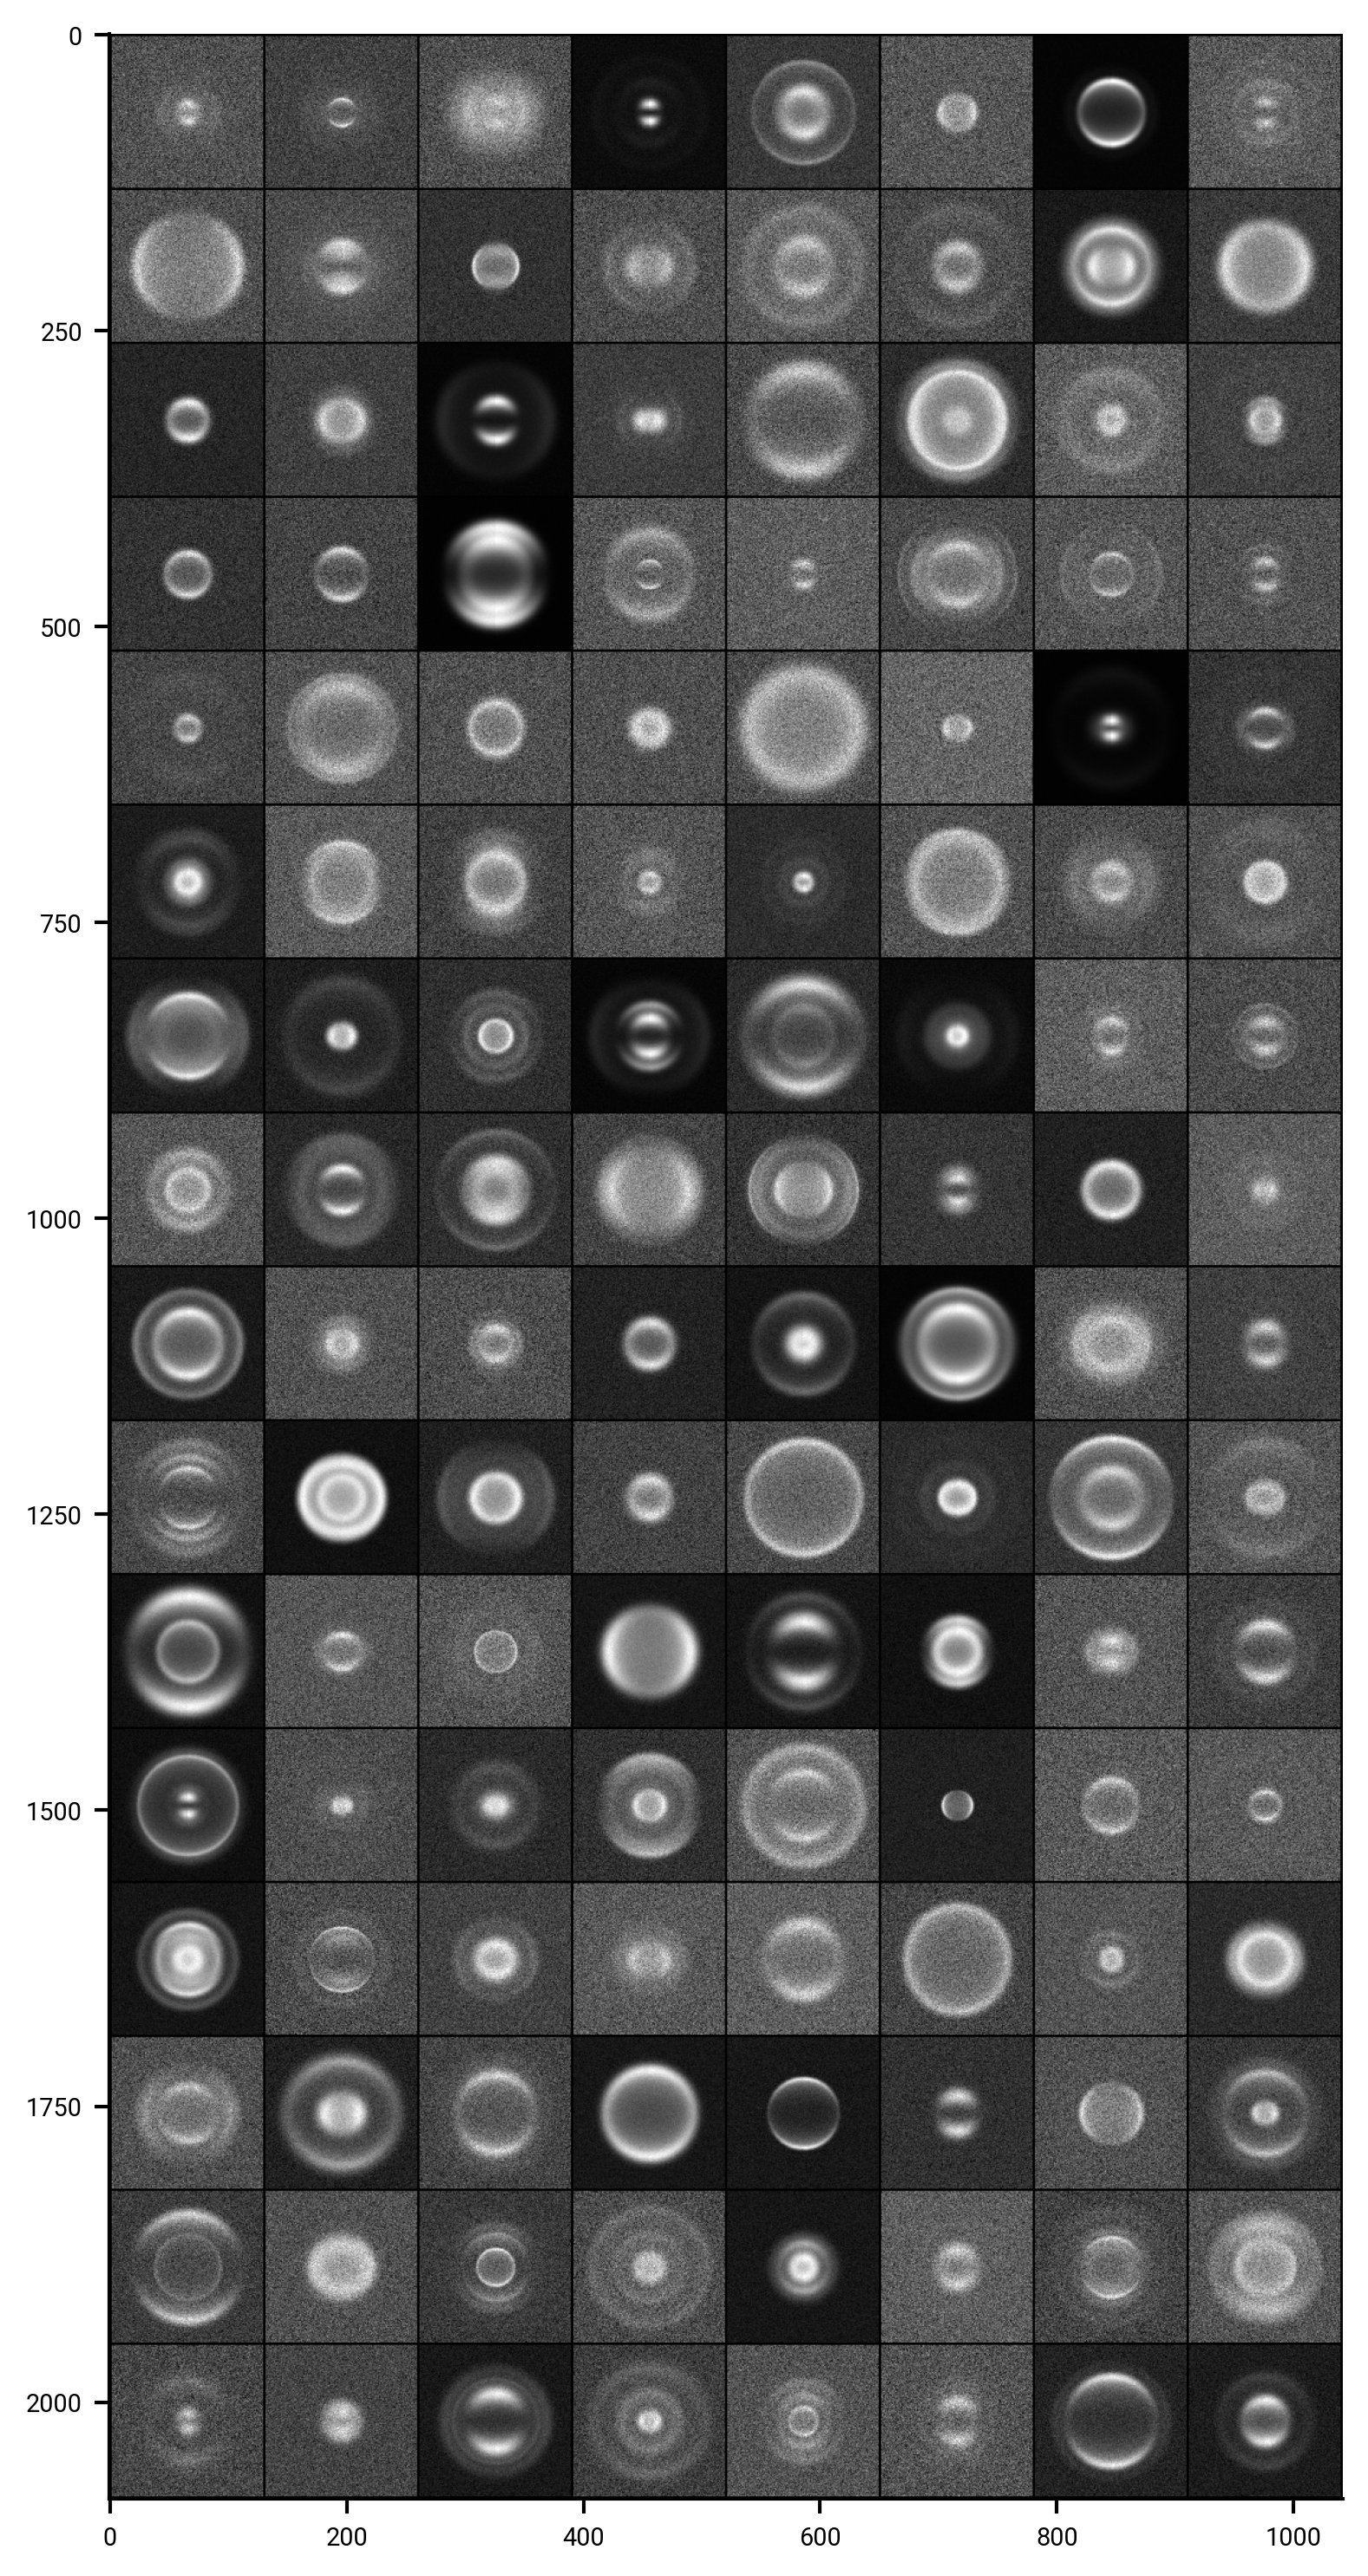

In [6]:
fig, ax = plt.subplots(figsize=(10,10))

show_torch_grid(input_images, ax)

### Load in the PyTorch model weights

In [7]:
model = VAE(1, 1, latent_dim=32, activation="silu")

In [8]:
model.load_state_dict(torch.load("../../models/betavae.pt"))

<All keys matched successfully>

## Comparing image profiles

In the following code, we're going to actually perform the reconstruction, but look at how it works for a single image. The image below constitutes multiple overlapping distributions, and the original image actually has quite poor SNR.

In [20]:
image_index = 70

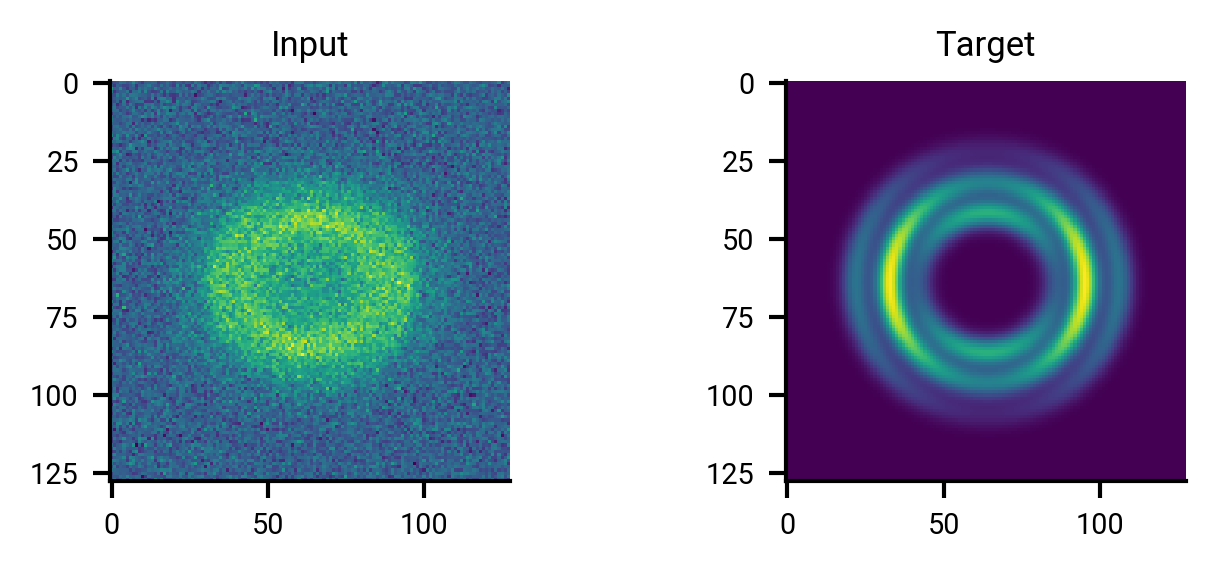

In [21]:
fig, axarray = plt.subplots(1, 2, figsize=(6, 2))

for ax, imageset, title in zip(axarray, [input_images, target_images], ["Input", "Target"]):
    ax.imshow(imageset[image_index][0])
    ax.set(title=title)
fig.tight_layout()

The model class has a `predict` method implemented that takes a single image input, and generates $n$ number of samples.

In [31]:
pred_Y = model.predict(input_images[image_index], n=256)

In [32]:
pred_Y = pred_Y.numpy()

Get the radial profiles from the images, and then use it average.

In [33]:
profiles = np.vstack([radial_profile(y[0], (64, 64))[None,:] for y in pred_Y])

In [34]:
# n x profile length
profiles.shape

(256, 91)

In [35]:
target_profile = radial_profile(target_images[image_index][0].numpy(), (64, 64))
mean_pred = profiles.mean(axis=0)
std_pred = profiles.std(axis=0)
plus_profile, minus_profile = mean_pred + (std_pred * 1.), mean_pred - (std_pred * 1.)

See what the generated images look like.

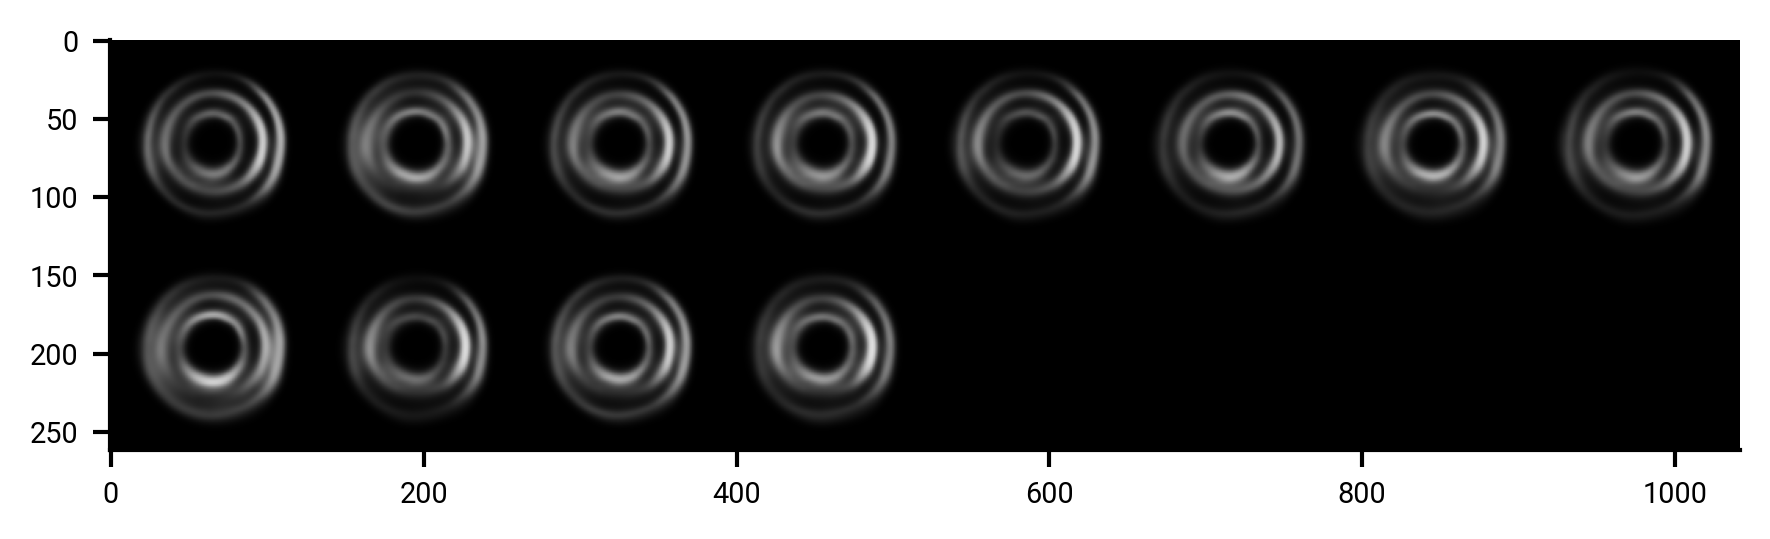

In [36]:
plt.imshow(make_grid(torch.from_numpy(pred_Y[:12])).permute(1, 2, 0))

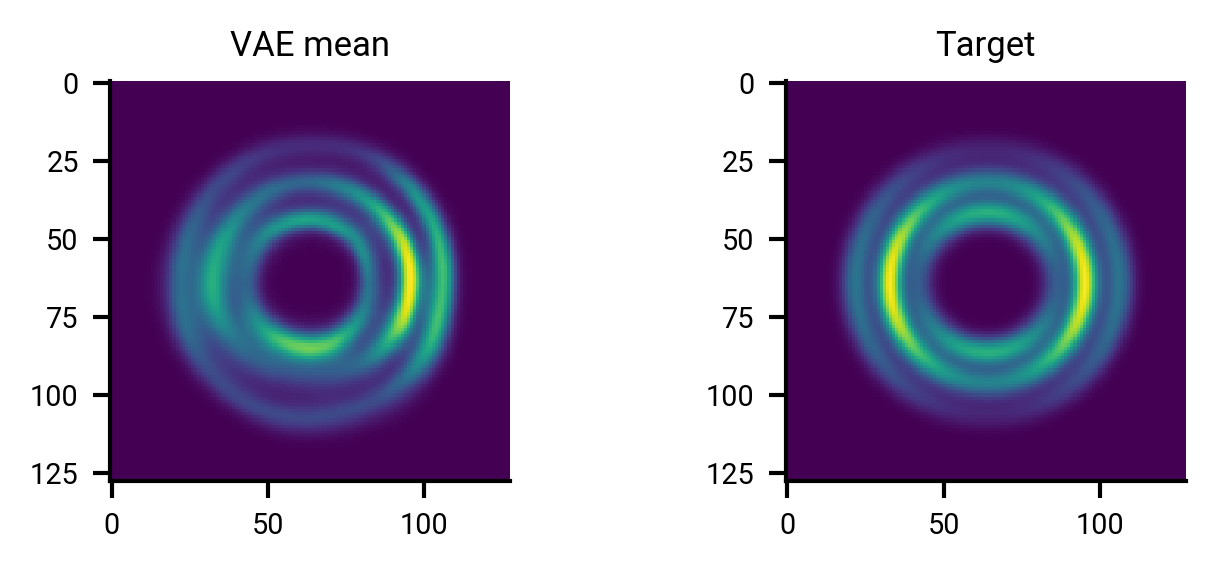

In [37]:
fig, axarray = plt.subplots(1, 2, figsize=(6, 2))

axarray[0].imshow(pred_Y.mean(axis=0)[0])
axarray[0].set(title="VAE mean")
axarray[1].imshow(target_images[image_index][0])
axarray[1].set(title="Target")
fig.tight_layout()

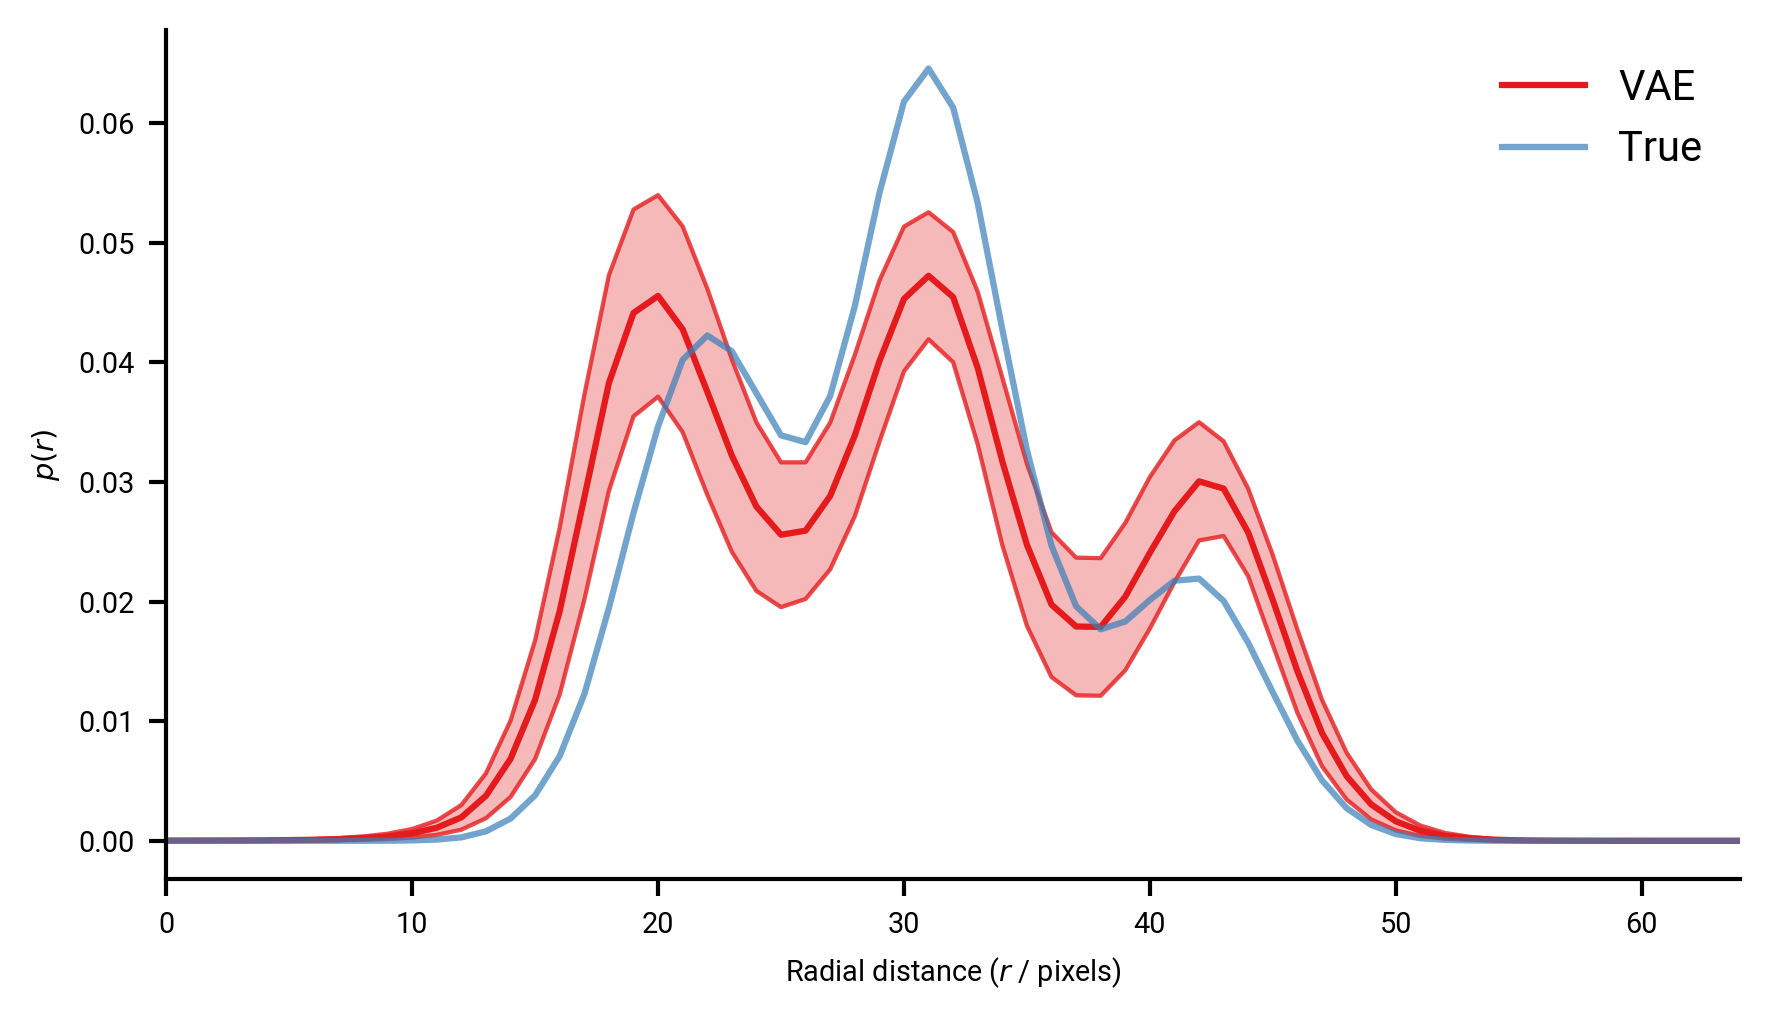

In [38]:
fig, ax = plt.subplots()

ax.plot(mean_pred / mean_pred.sum(), label="VAE", color="#e41a1c", lw=1.5)
ax.plot(plus_profile / mean_pred.sum(), color="#e41a1c", alpha=0.7)
ax.plot(minus_profile / mean_pred.sum(), color="#e41a1c", alpha=0.7)
ax.fill_between(np.arange(minus_profile.size), plus_profile / mean_pred.sum(), minus_profile / mean_pred.sum(), color="#e41a1c", alpha=0.3)
ax.plot(target_profile / target_profile.sum(), label="True", color="#377eb8", lw=1.5, alpha=0.7)
ax.set(ylabel="$p(r)$", xlabel="Radial distance ($r$ / pixels)", xlim=[0., 64.])
ax.legend()